# Combine all the data into once dataset

Once you've run the following notebooks,
- 01_stt_pecha_tools.ipynb
- 02_prodigy.ipynb
- 03_mv_saymore.ipynb

You get the following tsv files
- 01_stt_pecha_tools.tsv
- 02_prodigy.tsv
- 03_mv_saymore.tsv

Concatenate the tsv files and clean the data

In [99]:
stt_pecha_tools = "01_stt_pecha_tools.csv"
prodigy =         "02_prodigy_finalised.csv"

In [100]:
import pandas as pd
pecha_tools_df = pd.read_csv(stt_pecha_tools)
prodigy_df = pd.read_csv(prodigy)

In [101]:
prodigy_df = prodigy_df.rename(columns={'id': 'file_name', 'transcript':'uni'})

In [102]:
df = pd.concat([pecha_tools_df, prodigy_df], ignore_index=True)

In [103]:
bad_apples = pd.read_csv('04_bad_apples.csv')

In [104]:
df = df[~df['file_name'].isin(bad_apples['file_name'])]

Drop duplicates, duplicates were introduced from prodigy annotation tool. One of the reason we had to move away from it.

In [105]:
df.drop_duplicates(subset='file_name', keep="first", inplace=True)

### clean the combined tsv

Remove unwanted characters and remove transcriptions with english characters

In [106]:
import re
def clean_transcription(text):
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()

    text = re.sub("༌", "་",text) # there are two type of 'tsak' let's normalize 0xf0b to 0xf0c
    text = re.sub("༎", "།",text) # normalize double 'shae' 0xf0e to 0xf0d

    text = re.sub("ཽ", "ོ",text) # normalize
    text = re.sub("ཻ", "ེ",text) # normalize

    text = re.sub(r"་+", "་", text)
    text = re.sub(r"།+", "།", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+།", "།", text)

    text = re.sub(r"ཧཧཧ+", "ཧཧཧ", text)
    text = re.sub(r'འེ་འེ་(འེ་)+', r'འེ་འེ་འེ་', text)
    text = re.sub(r'ཧ་ཧ་(ཧ་)+', r'ཧ་ཧ་ཧ་', text)

    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\/\{\}\(\)\༽\》\༼\《\༅\༄\༈\༑\༠\\'\|\·\×\༆\༌\༎\༔\༷\༸\༾\ཿ\྄\྅\྆\྇\ྋ\࿒\ᨵ\​\’\„\╗\╚\ ྂ]'
    
    text = re.sub(chars_to_ignore_regex, '', text)+" "
    return text

def check_if_regex(text):
    text = str(text)
    regex = re.compile(r'[0-9a-zA-Z]+')
    match = re.search(regex, text)
    
    return bool(match)
    
print(check_if_regex('ཧཧ'))
print(check_if_regex('some text'))

False
True


In [107]:
df = df[df['uni'].str.len() > 0]

In [108]:
df = df[~df['uni'].apply(check_if_regex)]

In [109]:
df['uni'] = df['uni'].map(clean_transcription)

In [110]:
from datasets import Dataset
common_voice_train = Dataset.from_pandas(df)

In [111]:
def extract_all_chars(batch):
    all_text = " ".join(batch["uni"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [112]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)

Map:   0%|          | 0/719402 [00:00<?, ? examples/s]

In [113]:
vocab_list = list(set(vocab_train["vocab"][0]))

In [114]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

In [115]:
all = ''
for c in vocab_dict:
    all += c

In [78]:
# def show_if_has(text, ch):
#     if ch in text:
#         print(text)
# for text in df['uni']:
    # show_if_has(text, 'ཨྂ')

this


In [116]:
sorted(all)
print("num of unique chars:", len(all))
x="  ".join([str(i) for i in sorted(all)])
print(x)

print()

x="ཨ".join([str(i) for i in sorted(all)])
print(x)

num of unique chars: 104
   ༀ  ་  །  ༡  ༢  ༣  ༤  ༥  ༦  ༧  ༨  ༩  ཀ  ཁ  ག  གྷ  ང  ཅ  ཆ  ཇ  ཉ  ཊ  ཋ  ཌ  ཌྷ  ཎ  ཏ  ཐ  ད  དྷ  ན  པ  ཕ  བ  བྷ  མ  ཙ  ཚ  ཛ  ཝ  ཞ  ཟ  འ  ཡ  ར  ལ  ཤ  ཥ  ས  ཧ  ཨ  ཀྵ  ཪ  ཱ  ི  ཱི  ུ  ཱུ  ཷ  ེ  ོ  ཾ  ྀ  ཱྀ  ྃ  ྐ  ྑ  ྒ  ྔ  ྕ  ྖ  ྗ  ྙ  ྚ  ྛ  ྜ  ྞ  ྟ  ྠ  ྡ  ྡྷ  ྣ  ྤ  ྥ  ྦ  ྦྷ  ྨ  ྩ  ྪ  ྫ  ྭ  ྰ  ྱ  ྲ  ླ  ྴ  ྵ  ྶ  ྷ  ྸ  ྻ  ྼ  ᫥

 ཨༀཨ་ཨ།ཨ༡ཨ༢ཨ༣ཨ༤ཨ༥ཨ༦ཨ༧ཨ༨ཨ༩ཨཀཨཁཨགཨགྷཨངཨཅཨཆཨཇཨཉཨཊཨཋཨཌཨཌྷཨཎཨཏཨཐཨདཨདྷཨནཨཔཨཕཨབཨབྷཨམཨཙཨཚཨཛཨཝཨཞཨཟཨའཨཡཨརཨལཨཤཨཥཨསཨཧཨཨཨཀྵཨཪཨཱཨིཨཱིཨུཨཱུཨཷཨེཨོཨཾཨྀཨཱྀཨྃཨྐཨྑཨྒཨྔཨྕཨྖཨྗཨྙཨྚཨྛཨྜཨྞཨྟཨྠཨྡཨྡྷཨྣཨྤཨྥཨྦཨྦྷཨྨཨྩཨྪཨྫཨྭཨྰཨྱཨྲཨླཨྴཨྵཨྶཨྷཨྸཨྻཨྼཨ᫥


In [ ]:
! pip install pyewts

### Convert unicode tibetan characters into wylie format

In [117]:
import pyewts

converter = pyewts.pyewts()

df['wylie'] = df['uni'].apply(converter.toWylie)

In [118]:
df['char_len'] = df['uni'].str.len()

In [ ]:
! pip install matplotlib

<Axes: >

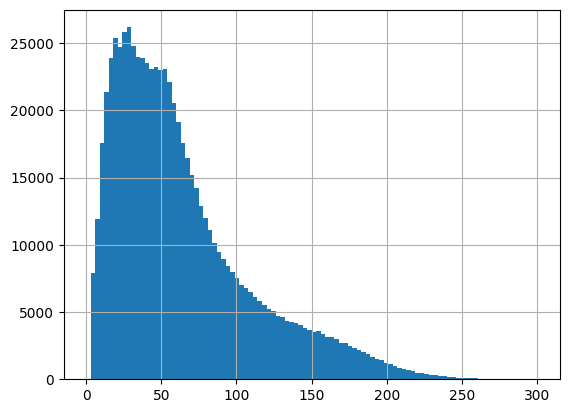

In [119]:
df['char_len'].hist(bins=100, range=(0, 300))

In [120]:
df['char_len'].describe()

count    719402.000000
mean         63.639995
std          46.423306
min           1.000000
25%          29.000000
50%          52.000000
75%          85.000000
max         385.000000
Name: char_len, dtype: float64

In [121]:
df.shape[0]

719402

In [122]:
upper_cutoff = 400
lower_cutoff = 5

In [123]:
df[df['char_len'] > upper_cutoff].shape[0], df[df['char_len'] < lower_cutoff].shape[0]

(0, 6030)

In [124]:
df[df['char_len'] > upper_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_longer_than_upper_cutoff.tsv', sep='\t', index=False)

In [125]:
df[df['char_len'] < lower_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_shorter_than_lower_cutoff.tsv', sep='\t', index=False)

In [126]:
df = df[(df['char_len'] < upper_cutoff) & (df['char_len'] > lower_cutoff)]

In [127]:
df.shape[0]

711469

### Get the audio time duration from the file name. 

There is to format for encoding the time span. We use the one with \_to\_ now. The difference came from the using a different library to do the Voice Activity Detection and splitting the audio for Tibetan Teachings. We have since started using pyannote-audio for all departments now.

In [128]:
def getTimeSpan(filename):

    filename = filename.replace(".wav", "")
    filename = filename.replace(".WAV", "")
    filename = filename.replace(".mp3", "")
    filename = filename.replace(".MP3", "")
    try:
        if "_to_" in filename:
            start, end = filename.split("_to_")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end = float(end)
            start = float(start)
            return abs(end - start)/1000
        else:
            start, end = filename.split("-")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end =   float(end)
            start = float(start)
            return abs(end - start)
    except Exception as err:
        print(f"filename is:'{filename}'. Could not parse to get time span.")
        return 0
    

getTimeSpan("STT_TT00031_03471.850-03477.44")

5.5900000000001455

In [129]:
df['audio_len'] = df['file_name'].apply(getTimeSpan)

In [130]:
df['audio_len'].describe()

count    711469.000000
mean          3.445852
std           2.628525
min           0.200000
25%           1.500000
50%           2.560000
75%           4.608000
max          13.650000
Name: audio_len, dtype: float64

<Axes: >

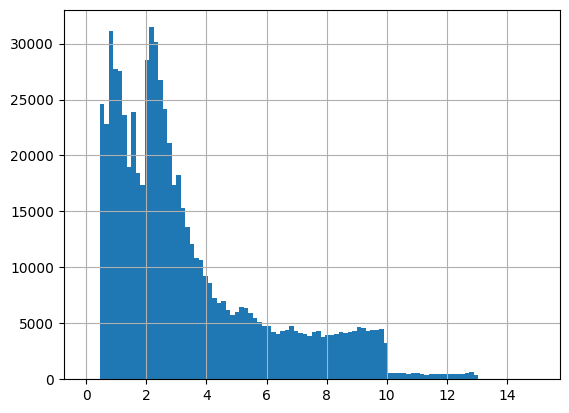

In [131]:
df['audio_len'].hist(bins=100, range=(0, 15))

In [132]:
df['url'] = 'https://d38pmlk0v88drf.cloudfront.net/wav16k/' + df['file_name'] + '.wav'

In [133]:
df['url'] = df['url'].map(lambda x : x.replace('#','%23'))

In [134]:
df = df[['file_name','uni', 'wylie', 'url', 'dept', 'grade', 'char_len',  'audio_len']]

In [135]:
df.head()

,file_name,uni,wylie,url,dept,grade,char_len,audio_len
0,STT_TT00694_0486_3161147_to_3166811,ཁྱོད་ཀྱིས་ང་ཡི་བུ་སློབ་རྣམས་སྐྱོངས་ཟེ་ད།རྗེ་བཙ...,khyod kyis nga yi bu slob rnams skyongs ze da/...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,136,5.664
1,STT_NS_M0321_0403_2828762_to_2830964,ཡང་ཨོ་དེ་ཉོས་ཡ་ཀ་ཅི་འདོད་པ་སླེབས་ཡ་ཅིག་ཡོད་བ།,yang o de nyos ya ka ci 'dod pa slebs ya cig y...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,46,2.202
2,STT_TT00656_0340_3174820_to_3179343,འཛམ་བུ་གླིང་ལ་དཔེ་ཤག་ཡོད་ངེ་དེ་ཚོ་ཞེ་བོ་འཁྱམ་འ...,'dzam bu gling la dpe shag yod nge de tsho zhe...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,95,4.523
3,STT_TT00656_0341_3182022_to_3185076,མཚན་ཚོགས་དེ་འདྲའི་ལ་འགྲོ་བསྡད་ཡ་འདྲ་བོ་དེ་འདྲའ...,mtshan tshogs de 'dra'i la 'gro bsdad ya 'dra ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,81,3.054
4,STT_TT00656_0344_3200868_to_3203268,སོ་སོ་གི་རེ་བ་དང་འདོད་པ་ཅིག་ཡོད་ཙང་འདི་འགྲུབ་ཡ...,so so gi re ba dang 'dod pa cig yod tsang 'di ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,54,2.400


In [136]:
df.to_csv('04_combine_all.tsv', sep='\t', index=False)

In [138]:
df['uni'].str.contains('ཧཧཧ').value_counts()

uni
False    711469
Name: count, dtype: int64

In [139]:
import pandas as pd

df = pd.read_csv('04_combine_all.tsv', sep='\t')

In [140]:
df.head()

,file_name,uni,wylie,url,dept,grade,char_len,audio_len
0,STT_TT00694_0486_3161147_to_3166811,ཁྱོད་ཀྱིས་ང་ཡི་བུ་སློབ་རྣམས་སྐྱོངས་ཟེ་ད།རྗེ་བཙ...,khyod kyis nga yi bu slob rnams skyongs ze da/...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,136,5.664
1,STT_NS_M0321_0403_2828762_to_2830964,ཡང་ཨོ་དེ་ཉོས་ཡ་ཀ་ཅི་འདོད་པ་སླེབས་ཡ་ཅིག་ཡོད་བ།,yang o de nyos ya ka ci 'dod pa slebs ya cig y...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,46,2.202
2,STT_TT00656_0340_3174820_to_3179343,འཛམ་བུ་གླིང་ལ་དཔེ་ཤག་ཡོད་ངེ་དེ་ཚོ་ཞེ་བོ་འཁྱམ་འ...,'dzam bu gling la dpe shag yod nge de tsho zhe...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,95,4.523
3,STT_TT00656_0341_3182022_to_3185076,མཚན་ཚོགས་དེ་འདྲའི་ལ་འགྲོ་བསྡད་ཡ་འདྲ་བོ་དེ་འདྲའ...,mtshan tshogs de 'dra'i la 'gro bsdad ya 'dra ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,81,3.054
4,STT_TT00656_0344_3200868_to_3203268,སོ་སོ་གི་རེ་བ་དང་འདོད་པ་ཅིག་ཡོད་ཙང་འདི་འགྲུབ་ཡ...,so so gi re ba dang 'dod pa cig yod tsang 'di ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_TT,3.0,54,2.400


#### Hours in each department

In [141]:
df.groupby('dept')['audio_len'].sum()/60/60

dept
STT_AB    112.682608
STT_CS     98.171318
STT_MV      6.594986
STT_NS    173.226921
STT_PC     15.606155
STT_TT    274.722774
Name: audio_len, dtype: float64

#### Total hours

In [142]:
df['audio_len'].sum()/60/60

681.0047608333332

In [143]:
# df.sort_values(by='audio_len', ascending=False, inplace=True)
df = df.sample(frac = 1)

In [144]:
df.iloc[0:100,[0, 1, 3, 5]].to_csv("04_random_100.tsv", index=False, sep='\t')
df.iloc[0:100,[0, 1, 3, 5]].head()

,file_name,uni,url,grade
150265,STT_TT00629_0095_551056_to_554640,བཅོམ་ལྡན་འདས་དང་ད།འཇིག་རྟེན་གི་ལྷ་གཅིག་གཉིས་བྱ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
553236,STT_TT00070_02547.500-02548.850,ལབ་བྱས།ཁོ།མགོ་གྲུང་པོ་འཁྲབ་བྱས།,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN
316945,STT_TT00690_0046_301408_to_304448,དོན་དམ་བྱང་ཆུབ་ཀི་སེམས་སྒོམ་པའི་སྒོ་ནས།རྐྱེན་ང...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
312269,STT_TT00534_0018_103101_to_107229,ཨུམ།ཀུན་མཁྱེན་ཕྱག་ན་པད་མོ་རྒྱལ་བའི་དབང་།བློ་བཟ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
230748,STT_AB00317_1579_5031049_to_5032209,་དཔེར་ན་སྒྲ་མངོན་གྱུར་ཡིན་པས་,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,2.0


In [145]:
df[df['grade'] == 3].groupby('dept').size()

dept
STT_AB     24617
STT_CS     21804
STT_NS     78562
STT_PC      5400
STT_TT    129288
dtype: int64